In [1]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`


In [2]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots
using DifferentialEquations


┌ Warning: thread = 1 warning: parsed expected 3 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV /Users/vs498/.julia/packages/CSV/XLcqT/src/file.jl:593


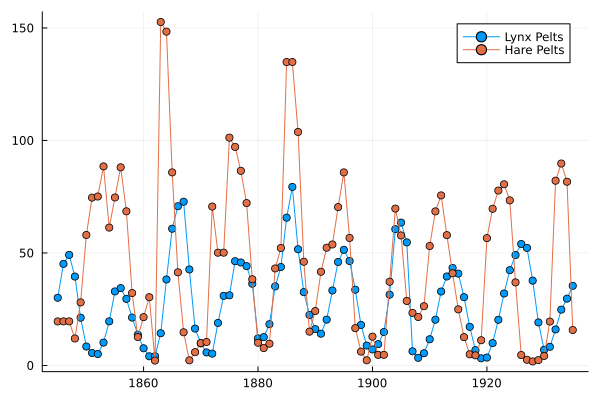

In [46]:
dat_path = joinpath(@__DIR__, "..", "data", "ecology")

dat = DataFrame(CSV.File(joinpath(dat_path, "Lynx_Hare.txt"), header=[:Year, :Hare, :Lynx]))[:, 1:3]

plot(dat.Year, dat.Lynx, markershape=:circle, label="Lynx Pelts")
plot!(dat.Year, dat.Hare, markershape=:circle, label="Hare Pelts")

In [47]:
function sim_lynx_hare(p, T, dt=.002)
    H₀, L₀, bh, mh, bl, ml = p
    n_steps = Int64(T / dt)
    L = zeros(n_steps)
    H = zeros(n_steps)
    H[1] = H₀
    L[1] = L₀
    for i ∈ 2:n_steps
        H[i] = H[i-1] + dt * H[i-1] * (bh - mh * L[i-1])
        L[i] = L[i-1] + dt * L[i-1] * (bl * H[i-1] - ml)
    end
    return (L, H)
end

sim_lynx_hare (generic function with 2 methods)

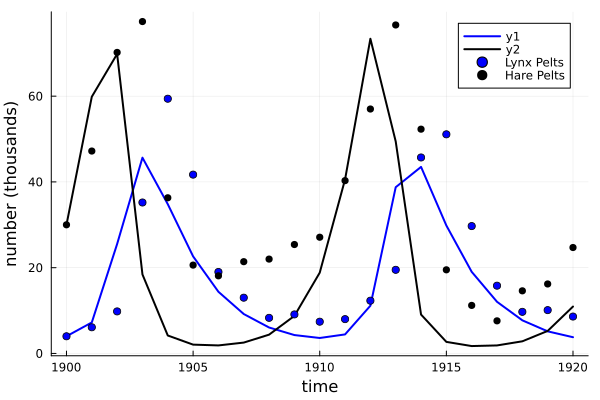

In [8]:
θ = [dat.Hare[1], dat.Lynx[1], 1.0, 0.06, 0.025, 0.5]
z = sim_lynx_hare(θ, 21, 0.01);

plot(1900:1920, z[1][1:100:end], lw=2, xlab="time", ylab="number (thousands)", c=:blue)
plot!(1900:1920, z[2][1:100:end], lw=2, c=:black)

scatter!(dat.Year, dat.Lynx, markershape=:circle, label="Lynx Pelts", c=:blue)
scatter!(dat.Year, dat.Hare, markershape=:circle, label="Hare Pelts", c=:black)

In [63]:
function lh_sim(p, T)
    H₀, L₀, bh, mh, bl, ml, ch, cl, σh, σl = p

    LH₁ = [L₀, H₀]
    θ = [bh, mh, bl, ml]

    prob = ODEProblem(lynx_hare!, LH₁, T-1, θ)
    sol = solve(prob, saveat=1)

    L = map(first, sol.u[1:T])
    H = map(last, sol.u[1:T])
    μL = L .* cl
    μH = H .* ch

    return (L, H, μL, μH)

end
    

lh_sim (generic function with 1 method)

In [62]:
function lh_loglik(p, lynx_pop, hare_pop, T)
    H₀, L₀, bh, mh, bl, ml, ch, cl, σh, σl = p

    LH₁ = [L₀, H₀]
    θ = [bh, mh, bl, ml]

    prob = ODEProblem(lynx_hare!, LH₁, T-1, θ)
    sol = solve(prob, saveat=1)
     
    μL = map(first, sol.u[1:T]) .* cl
    μH = map(last, sol.u[1:T]) .* ch
    if all(μL .> 0.0) && all(μH .> 0.0)
        ll = sum(logpdf.(LogNormal.(log.(μL), σl), lynx_pop)) + sum(logpdf.(LogNormal.(log.(μH), σh), hare_pop))
    else
        ll = -Inf
    end
    return ll
end

lh_loglik (generic function with 2 methods)

In [60]:
lb = [100.0, 10.0, 0.3, 0.05, 0.005, 0.1, 0.15, 0.15, 0.1, 0.1]
ub = [150.0, 50.0, 0.4, 0.1, 0.02, 1.0, 0.25, 0.25, 5.0, 5.0]
p0 = [125.0, 25.0, 0.35, 0.07, 0.01, 0.5, 0.201, 0.201, 0.5, 0.5]

optim_out = Optim.optimize(p -> -lh_loglik(p, dat.Lynx, dat.Hare, nrow(dat), lb, ub, p0)

Base.Meta.ParseError: ParseError:
# Error @ /Users/vs498/Teaching/BEE4850/website/slides/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:5:89

optim_out = Optim.optimize(p -> -lh_loglik(p, dat.Lynx, dat.Hare, nrow(dat), lb, ub, p0)
#                                                                                       └ ── Expected `)`

In [50]:
θ2 = optim_out.minimizer
@show θ2;


θ2 = [125.18330781873097, 23.946059495097273, 0.39857082935919375, 0.053139707350879604, 0.007887602759231295, 0.9017664312476831, 0.2375588989644166, 0.248504493458344, 0.9783089581173059, 0.9979518072229241]
θ = [149.99999999999997, 10.000000000000002, 0.39999999999999997, 0.05000000000000001, 0.005000000000000001, 0.5867559583268103, 0.17199999999999996, 0.17199999999999996, 0.661067531501969, 0.9999999999999999]


In [59]:
function lh_prior(p)
    H₀, L₀, bh, mh, bl, ml, ch, cl, σh, σl = p
    lp = 0
    lp += logpdf(truncated(Normal(1, 0.5), 0.0, Inf), bh)
    lp += logpdf(truncated(Normal(0.05, 0.05), 0.0, Inf), bl)
    lp += logpdf(truncated(Normal(0.05, 0.05), 0.0, Inf), mh)
    lp += logpdf(truncated(Normal(1, 0.5), 0.0, Inf), ml)

    lp += logpdf(Exponential(), σh)
    lp += logpdf(Exponential(), σl)
    lp += logpdf(LogNormal(log(10), 1), H₀)
    lp += logpdf(LogNormal(log(10), 1), L₀)
    lp += logpdf(Beta(40, 100), ch)
    lp += logpdf(Beta(40, 100), cl)

    return lp
end

function lh_posterior(p, lynx_pop, hare_pop, T)
    lp = lh_prior(p)
    if lp > -Inf
        ll = lh_loglik(p, lynx_pop, hare_pop, T)
        lpost = lp + ll
    else
        lpost = -Inf
    end

    return lpost
end

lh_posterior (generic function with 2 methods)

In [55]:
lb = [10.0, 10.0, 0.3, 0.05, 0.005, 0.1, 0.15, 0.15, 0.1, 0.1]
ub = [150.0, 150.0, 0.4, 0.1, 0.02, 1.0, 0.25, 0.25, 5.0, 5.0]
p0 = [125.0, 25.0, 0.35, 0.07, 0.01, 0.5, 0.201, 0.201, 0.5, 0.5]

optim_out = Optim.optimize(p -> -lh_posterior(p, dat.Lynx, dat.Hare, nrow(dat), .002), lb, ub, p0)
θ_map = optim_out.minimizer

10-element Vector{Float64}:
 126.92465306956984
  22.30014297264054
   0.38458986984163723
   0.051242261833281844
   0.005415836527505042
   0.5279401104378161
   0.23924661901979516
   0.23941019074222156
   1.3545899148648013
   3.1241996696195504

In [56]:
@show θ2;
@show θ_map;

θ2 = [125.18330781873097, 23.946059495097273, 0.39857082935919375, 0.053139707350879604, 0.007887602759231295, 0.9017664312476831, 0.2375588989644166, 0.248504493458344, 0.9783089581173059, 0.9979518072229241]
θ_map = [126.92465306956984, 22.30014297264054, 0.38458986984163723, 0.051242261833281844, 0.005415836527505042, 0.5279401104378161, 0.23924661901979516, 0.23941019074222156, 1.3545899148648013, 3.1241996696195504]


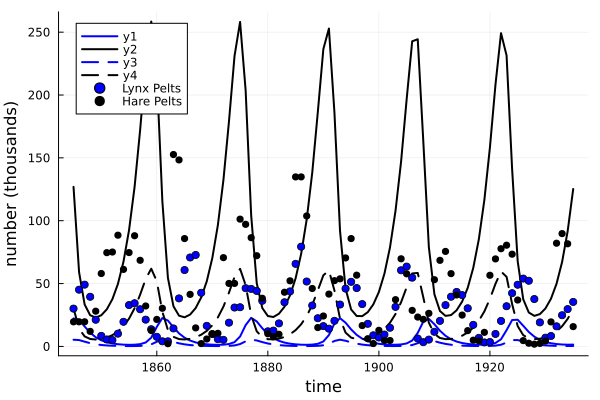

In [72]:
lh_mle = lh_sim(θ2, nrow(dat))
lh_map = lh_sim(θ_map, nrow(dat))

plot(dat.Year, lh_map[1], lw=2, xlab="time", ylab="number (thousands)", c=:blue)
plot!(dat.Year, lh_map[2], lw=2, c=:black)
plot!(dat.Year, lh_map[3], lw=2, c=:blue, linestyle=:dash)
plot!(dat.Year, lh_map[4], lw=2, c=:black, linestyle=:dash)


scatter!(dat.Year, dat.Lynx, markershape=:circle, label="Lynx Pelts", c=:blue)
scatter!(dat.Year, dat.Hare, markershape=:circle, label="Hare Pelts", c=:black)

In [41]:
function lynx_hare!(dLH, LH, θ, t)
    L, H = LH
    bh, mh, bl, ml = θ

    dLH[1] = dL = (bl * H - ml) * L
    dLH[2] = dH = (bh - mh * L) * H
end

@model function lynx_hare_model(N, L, H)
    b_h ~ truncated(Normal(1, 0.5), 0.0, Inf)
    b_l ~ truncated(Normal(0.05, 0.05), 0.0, Inf)
    m_h ~ truncated(Normal(0.05, 0.05), 0.0, Inf)
    m_l ~ truncated(Normal(1, 0.5), 0.0, Inf)
    
    σ_h ~ Exponential()
    σ_l ~ Exponential()
    h₁ ~ LogNormal(log(10), 1)
    l₁ ~ LogNormal(log(10), 1)
    p_h ~ Beta(40, 100)
    p_l ~ Beta(40, 100)
    
    LH₁ = [l₁, h₁]
    θ = [b_h, m_h, b_l, m_l]
    prob = ODEProblem(lynx_hare!, LH₁, N-1, θ)
    sol = solve(prob, saveat=1)
    if length(sol.u) < N
        Turing.@addlogprob! -Inf
    else
        μ_l = map(first, sol.u[1:N]) .* p_l
        μ_h = map(last, sol.u[1:N]) .* p_h
        # sometime solution might end up with negative population :)
        if all(μ_l .> 0.0) && all(μ_h .> 0.0)
            logμ_l = log.(μ_l)
            logμ_h = log.(μ_h)
            @. L ~ LogNormal(logμ_l, σ_l)
            @. H ~ LogNormal(logμ_h, σ_h)
        else
            Turing.@addlogprob! -Inf
        end
    end
end

lynx_hare_model (generic function with 2 methods)

In [42]:
mod = lynx_hare_model(nrow(dat), dat.Lynx, dat.Hare)
lh_mle = maximum_likelihood(mod)

┌ Warning: First function call produced NaNs. Exiting. Double check that none of the initial conditions, parameters, or timespan values are NaN.
└ @ OrdinaryDiffEqCore /Users/vs498/.julia/packages/OrdinaryDiffEqCore/33WQj/src/initdt.jl:131
┌ Warning: At t=0.0, dt was forced below floating point epsilon 5.0e-324, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of ForwardDiff.Dual{ForwardDiff.Tag{DifferentiationInterface.FixTail{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{b_h::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_h, typeof(identity)}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64, Float64, Float64}}, Vector{AbstractPPL.VarName{:b_h, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b_l::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_l, typeof(identity)}, Int64}, Vector{Truncated{Normal{Flo

ModeResult with maximized lp of -122.96
[0.5401317335375284, 0.013457601923169837, 0.010101835962975323, 0.7966464402605938, 0.21843925265434713, 0.22002413747029215, 60.92511399188908, 15.712610497131674, 0.5677323895605597, 0.37194656140202553]

In [14]:
lh_map = maximum_a_posteriori(mod)

┌ Warning: First function call produced NaNs. Exiting. Double check that none of the initial conditions, parameters, or timespan values are NaN.
└ @ OrdinaryDiffEqCore /Users/vs498/.julia/packages/OrdinaryDiffEqCore/33WQj/src/initdt.jl:131
┌ Warning: At t=0.0, dt was forced below floating point epsilon 5.0e-324, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of ForwardDiff.Dual{ForwardDiff.Tag{DifferentiationInterface.FixTail{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{b_h::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_h, typeof(identity)}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64, Float64, Float64}}, Vector{AbstractPPL.VarName{:b_h, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b_l::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_l, typeof(identity)}, Int64}, Vector{Truncated{Normal{Flo

ModeResult with maximized lp of -130.98
[0.5389454051022228, 0.00428642007160546, 0.004658335425513784, 0.8029366255474335, 0.21720938675245963, 0.21952219805487944, 190.5346329649186, 33.722723573078355, 0.1777730246798199, 0.1718687509417415]